In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [31]:
ox_data = pd.read_csv('../data/Global/OxCGRT_latest.csv')
owid_data = pd.read_csv('../data/Global/owid-covid-data.csv')

ox_data['Date_clean'] = pd.to_datetime(ox_data['Date'].astype(str))
owid_data['date'] = pd.to_datetime(owid_data['date'])

/home/sbg/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [32]:
ox_data_us = ox_data.loc[ox_data['CountryName']=='United States']

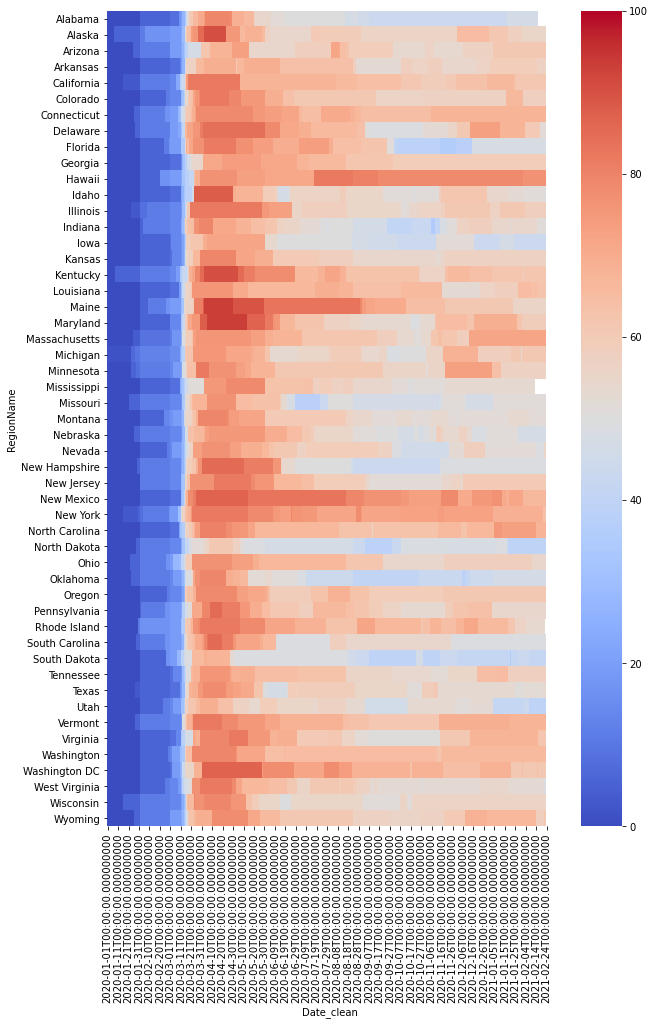

In [8]:
fig,ax = plt.subplots(figsize=(10, 15))
sns.heatmap(ox_data_us.groupby(['RegionName', 'Date_clean'])['ContainmentHealthIndex'].mean().unstack(), 
            vmin=0, vmax=100, cmap='coolwarm', ax=ax)
plt.show()

# StringencyIndex or ContainmentHealthIndex

Text(0.5, 0, 'corr between Stringency and ContainmentHealth indices')

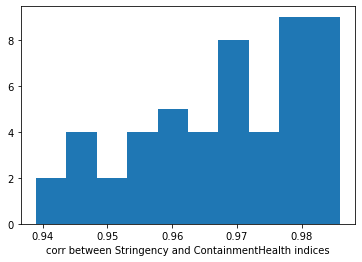

In [23]:
corrs = []

for state in ox_data_us['RegionName'].unique()[1:]:
    slc = ox_data_us.loc[ox_data_us['RegionName'] == state]
    msk = ~slc['StringencyIndex'].isna()
    corrs.append(np.corrcoef(slc['StringencyIndex'][msk], slc['ContainmentHealthIndex'][msk])[0,1])
    
plt.hist(corrs)
plt.xlabel('corr between Stringency and ContainmentHealth indices')

In [34]:
owid_data['date'].unique().shape

# 426 days of data

(426,)

In [41]:
owid_data['location'].unique().shape

# ISO code and location can be used interchangeably, so we'll use location (which is really just country)
# 214 unique countries of data

(214,)

Argentina          426
Mexico             426
Thailand           423
Taiwan             411
South Korea        406
                  ... 
Macao               11
Anguilla            11
Northern Cyprus      9
Saint Helena         1
Greenland            1
Name: location, Length: 214, dtype: int64


Text(0.5, 0, 'Days of data in OWID dataset (by country)')

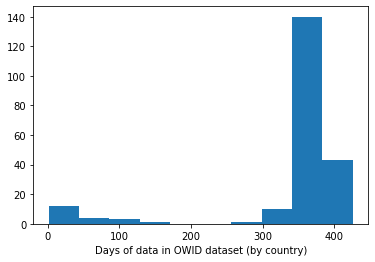

In [46]:
print(owid_data['location'].value_counts())

plt.hist(owid_data['location'].value_counts())
plt.xlabel(r'Days of data in OWID dataset (by country)')

# the data is not given over the same days in each case, so this will complicate things

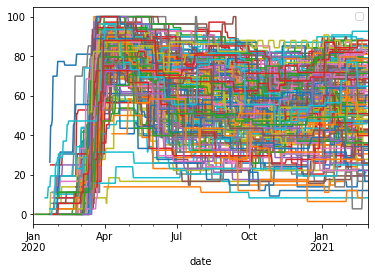

In [51]:
# Look at stringency index vs. time binned by country

owid_data.groupby(['date', 'location'])['stringency_index'].mean().unstack().plot()
plt.legend([],[])

# So let's asume that a change in stringency index is instantaneous, and we have to consider the 14-day look-ahead impact
# in hospitalizations to really gauge the response

In [103]:
owid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [106]:
# How many countries have a stringency index?
msk = ~owid_data['stringency_index'].isna()
owid_data[msk]['location'].unique().shape

# 177 countries have a stringency index measured at some point

(177,)

In [110]:
msk = ~owid_data['new_cases_per_million'].isna()
owid_data[msk]['location'].unique().shape

# Only 29 countries have hosp_patients_per_million measured
# 187 countries have new_deaths_per_million
# 198 countries have new_cases_per_million

(198,)

In [193]:
# Let's do a more simple version of this test
# Ignore the lag
# For each day, take all of the present countries with non-NaN metric, store the metric and the stringency

#metric = 'new_deaths_per_million'
metric = 'new_deaths_smoothed_per_million'
dates = owid_data['date'].unique()
dates.sort()

result = pd.DataFrame(index=dates)
result['stringency_index'] = [[]] * len(result)
result['metric'] = [[]] * len(result)

for d in dates:    
    slc = owid_data.loc[owid_data['date'] == d]
    
    lookahead = d + np.timedelta64(28, 'D') # 14 day look-ahead
    slc_lk = owid_data.loc[owid_data['date'] == lookahead]
        
    # List of countries included in both dates
    countries = np.intersect1d(slc['location'].unique(), slc_lk['location'].unique())
    slc = slc.loc[slc['location'].isin(countries)].sort_values('location')
    slc_lk = slc_lk.loc[slc_lk['location'].isin(countries)].sort_values('location')
    
    assert np.all(slc['location'].values == slc_lk['location'].values)
    
    # now they are properly organized by country
    indx = slc['stringency_index'].values.ravel()
    metr = slc_lk[metric].values.ravel()
        
    msk = np.logical_and(~np.isnan(indx),~np.isnan(metr))
        
    #msk = np.logical_and(~slc[metric].isna(),~slc['stringency_index'].isna())
    #msk = np.logical_and(~slc_lk[metric].values.isnan(),~slc['stringency_index'].values.isnan())
    # Mask for countries that have an index on one day and the metric on the lookahead date
    # Need an extra step: msk first for the same countries, then sort by country
    
    result.loc[d, 'stringency_index'] = indx[msk]
    result.loc[d, 'metric'] = metr[msk]

In [194]:
# loop over days
# split into high stringency, low stringency

hs_vals = []
ls_vals = []
med_strin = []

for d in dates:
    indx = result.loc[d,'stringency_index']
    metric = result.loc[d,'metric']
    
    med_strin = np.median(indx)
    
    result.loc[d,'med_strin'] = med_strin
    result.loc[d,'hs_val'] = np.mean(metric[indx >= med_strin])
    result.loc[d,'ls_val'] = np.mean(metric[indx < med_strin])

/home/sbg/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sbg/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

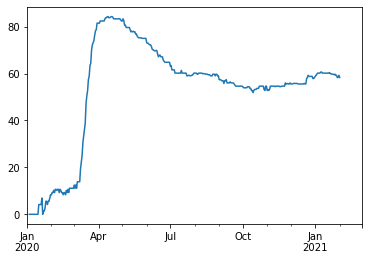

In [195]:
result['med_strin'].plot()

# Median stringency vs time

Text(0, 0.5, 'Mean deaths per million')

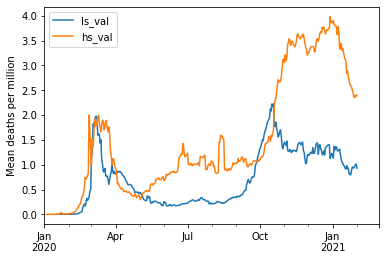

In [196]:
result[['ls_val','hs_val']].plot()
plt.ylabel('Mean deaths per million')

# Takeaway here is that the high stringency states have more deaths over time

<AxesSubplot:>

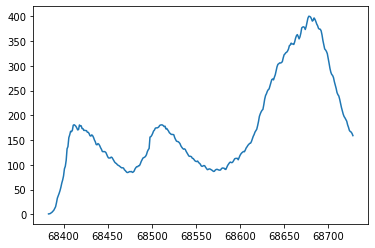

In [180]:
owid_data.loc[owid_data['location'] == 'United States']['hosp_patients_per_million'].plot()

# How much data do we actually have on weekly host admissions?

In [63]:
owid_data['weekly_hosp_admissions_per_million'].isna().sum()

# Total length is 72096

70914

In [60]:
owid_data['hosp_patients'].isna().sum()

62939

In [61]:
owid_data['iso_code'].isna().sum()

0

In [62]:
owid_data.shape

(72096, 59)